# Predicting with CNN Model
# Model 2.2 
# Generation script v2
# Full-sized synthetic & TEM images (+ watershed algorithm)
#### Ross Carmichael
#### 19/10/21

In [1]:
import tensorflow as tf
from tensorflow.keras.layers.experimental import preprocessing 

import tensorflow_datasets as tfds
from tensorflow_examples.models.pix2pix import pix2pix

from sklearn.preprocessing import LabelEncoder

from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline
from glob import glob
import os
import numpy as np
import cv2
from MightyMosaic import MightyMosaic

from scipy import ndimage as ndi

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
model = tf.keras.models.load_model('saved_model/model_2.2_100_epochs.h5')
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 model (Functional)             [(None, 64, 64, 96)  1841984     ['input_2[0][0]']                
                                , (None, 32, 32, 14                                               
                                4),                                                               
                                 (None, 16, 16, 192                                               
                                ),                                                          

# Load in some images to be segmented

In [3]:
def load_data(path, tif=False):
    if tif:
        images = sorted(glob(os.path.join(path, "*.tif")))
        return images
    else:
        images = sorted(glob(os.path.join(path, "*.png")))
        return images

def read_image(path):
    image = cv2.imread(path, cv2.IMREAD_COLOR)
    image = image / 255.0
    image = image.astype(np.float32)

    return image

In [4]:
path = "../full-size/synthetic/"

# File paths
images = load_data(path, tif=True)
print(f"Images: {len(images)}")

synthetic_images = [read_image(image) for image in images]
print(images[0], synthetic_images[0].shape)

Images: 36
../full-size/synthetic/particles0.tif (512, 512, 3)


# Split the full-sized images into mosaics and predict

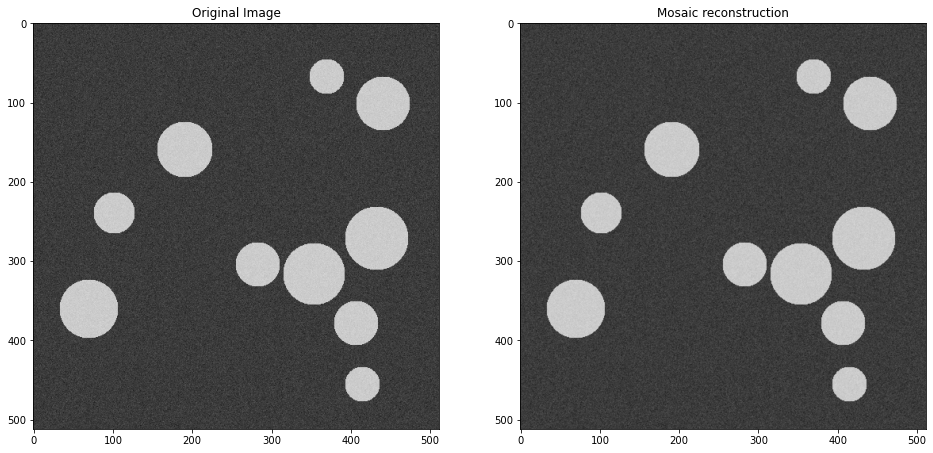

Mosaic shape: (16, 16, 128, 128, 3)


In [5]:
mosaic1 = MightyMosaic.from_array(synthetic_images[0], (128,128), overlap_factor=4, fill_mode='reflect')
plt.figure(figsize=(16,16))
plt.subplot(121)
plt.title("Original Image")
plt.imshow(synthetic_images[0])
plt.subplot(122)
plt.title("Mosaic reconstruction")
plt.imshow(mosaic1.get_fusion(), interpolation='bilinear', vmin=0, vmax=1)
plt.show()
print("Mosaic shape: " + str(mosaic1.shape))

In [6]:
prediction1 = mosaic1.apply(model.predict, progress_bar=True)

In [7]:
fused_prediction1 = prediction1.get_fusion()
labels1 = np.argmax(fused_prediction1, axis=-1)

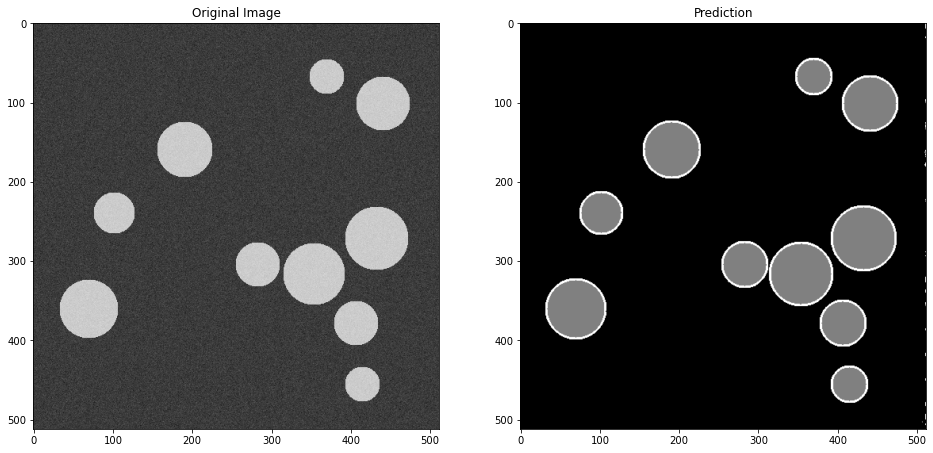

In [8]:
plt.figure(figsize=(16,16))
plt.subplot(121)
plt.title("Original Image")
plt.imshow(synthetic_images[0])

plt.subplot(122)
plt.title("Prediction")
plt.imshow(labels1, interpolation='bilinear', cmap=plt.cm.gray)
plt.show()

# Apply the watershed algorithm

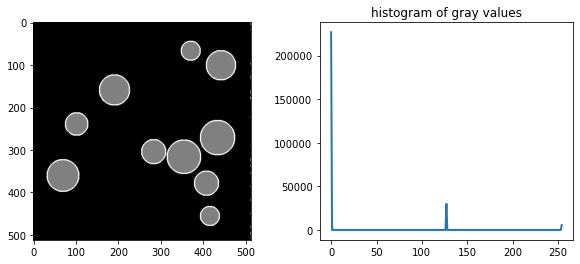

In [9]:
from skimage.exposure import histogram

img = labels1*127

hist, hist_centers = histogram(img)   # generate histogram data for cropped image

fig, axes = plt.subplots(1, 2, figsize=(10, 4))   # create figure with two sub-plots
axes[0].imshow(img, cmap=plt.cm.gray)   # display cropped image
axes[0].axis('on')
axes[1].plot(hist_centers, hist, lw=2)   # plot histogram
axes[1].set_title('histogram of gray values')
plt.show()

In [10]:
# Area opening removes all bright structures of an image with a surface smaller than area_threshold.
# Clear border removes objects touching the border of the image
from skimage.morphology import area_opening
from skimage.segmentation import clear_border

# img = area_opening(img, area_threshold=200)
#img = clear_border(img)

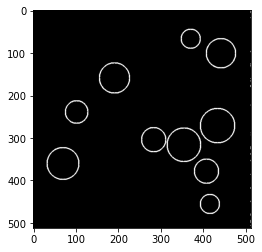

In [11]:
edges = np.copy(img)
edges[edges==127] = 0
plt.imshow(edges, cmap=plt.cm.gray)
plt.show()

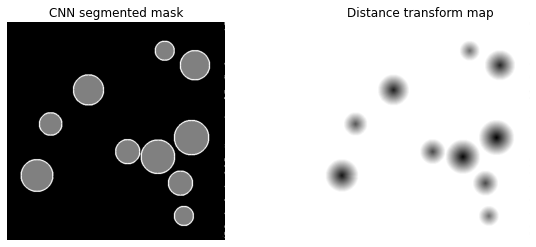

In [12]:
# turn objects into catchment basin using a distance map
dis = ndi.distance_transform_edt(img)
ndis = -dis

fig, axes = plt.subplots(1, 2, figsize=(10, 4))   # create figure with two sub-plots
axes[0].set_title('CNN segmented mask')
axes[0].imshow(img, cmap=plt.cm.gray)   # display binary image
axes[0].axis('off')
axes[1].set_title('Distance transform map')
axes[1].imshow(ndis, cmap=plt.cm.gray)   # display distance image
axes[1].axis('off')
plt.show()

In [13]:
# generate markers as local maxima in distance map
from skimage.feature import peak_local_max
locedge = 3
locreg  = np.ones((locedge, locedge))
locmax  = peak_local_max(dis, min_distance=6)   # particle centres near local maxima in distance map of eroded image


mask = np.zeros(dis.shape, dtype=bool)   # set up mask with same shape as distance map and pre-populate with False
mask[tuple(locmax.T)] = True   # set mask to True at coordinates of local maxima
markers, num_markers = ndi.label(mask, structure=None,)   # labels objects in mask, False or 0 is considered background
print("Number of markers     = {}".format(num_markers))

Number of markers     = 10


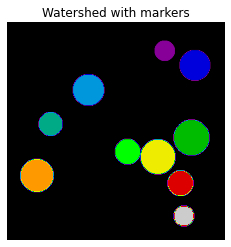

In [14]:
# now do watershed with markers
from skimage.segmentation import watershed
marker_watershed = watershed(ndis, markers=markers, mask=img, watershed_line=True)   # watershed and label image

fig, ax = plt.subplots( figsize=(10, 4))  

ax.set_title('Watershed with markers')
ax.imshow(marker_watershed, cmap=plt.cm.nipy_spectral)   # display watershed image with different colours for different regions
ax.axis('off')
plt.show()

In [15]:
# get region properties
from skimage.measure import regionprops
regprop = regionprops(marker_watershed)

# Loop through regprop and append area of each labeled object to list.
particles = []
cutoff_area = 500

for i in range(len(regprop)):
    area = regprop[i].area
    if area < cutoff_area:
        continue
    yc   = regprop[i].centroid[0]
    xc   = regprop[i].centroid[1]
    
    particles.append([yc,xc,area])

<ipython-input-16-c106282e6e30>:19: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  circ = Circle((xc,yc),rr,alpha=1.0,edgecolor='red',Fill=False,linewidth=2.0)


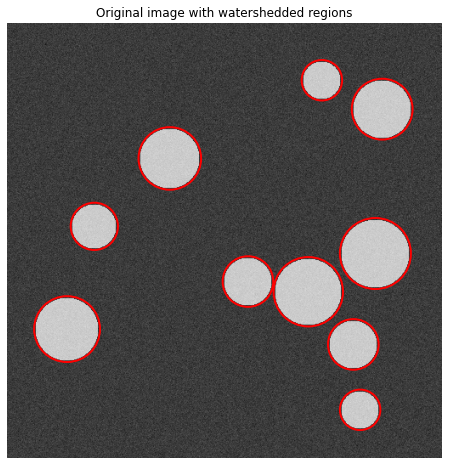

In [16]:
# check whether correct particles found by drawing particle centers
from matplotlib.patches import Circle
from math import sqrt, pi

# Create a figure. Equal aspect so circles look circular
fig,ax = plt.subplots(1, figsize=(8,8))
ax.set_aspect('equal')

# Show the image
ax.imshow(synthetic_images[0], cmap=plt.cm.gray)
ax.set_title('Original image with watershedded regions')

# Now, loop through coord arrays, and create a circle at each x,y pair
rr = 1
for item in particles:
    xc = item[1]
    yc = item[0]
    rr = sqrt(item[2]/pi)
    circ = Circle((xc,yc),rr,alpha=1.0,edgecolor='red',Fill=False,linewidth=2.0)
    ax.add_patch(circ)

    # Show the image
plt.axis('off')
plt.show()

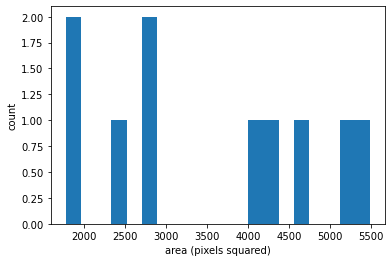

In [17]:
# plot histogram of radii
areas = []
for item in particles:
    area = item[2]
    areas.append(area)

# plot image histogram
areas_array = np.array(areas)

plt.hist(areas_array,bins=20)
plt.xlabel("area (pixels squared)")
plt.ylabel("count")
plt.show()

### For synthetic images, the size distribution will reflect the distribution used when generating the images - it should be random normal for the current script. As a qualitative check for the model, compare the size distribution for the generated images when their made and compare it to the segmented images using the model. The model is the thing in between and this provides a way to check how well the model did.


# Try with real TEM images now

In [18]:
path = "../full-size/tem/"

# File paths
images = load_data(path, tif=True)
print(f"Images: {len(images)}")

tem_images = [read_image(image) for image in images]
print(images[0], tem_images[0].shape)

tem_images = [1-img for img in tem_images]

Images: 8
../full-size/tem/ASM306_grayscale_0000.tif (4096, 4096, 3)


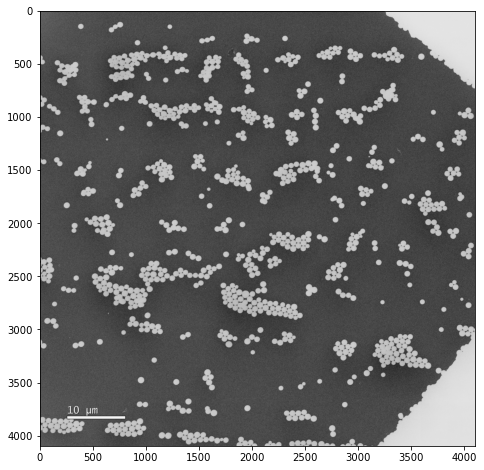

In [19]:
plt.figure(figsize=(8,8))
plt.imshow(tem_images[0])
plt.show()

### Median or Gaussian filter
#### Made the salt and pepper noise on the segmented image much worse ---> Try a Gaussian filter next?

In [20]:
# #from skimage.filters import median
# from skimage.filters import gaussian

# #filtered = median(tem_images[0])
# filtered = gaussian(tem_images[0])

# fig, ax = plt.subplots(1,2, figsize=(14, 14))
# ax[0].imshow(tem_images[0])
# ax[1].imshow(filtered)
# plt.show()

# tem_images[0] = filtered

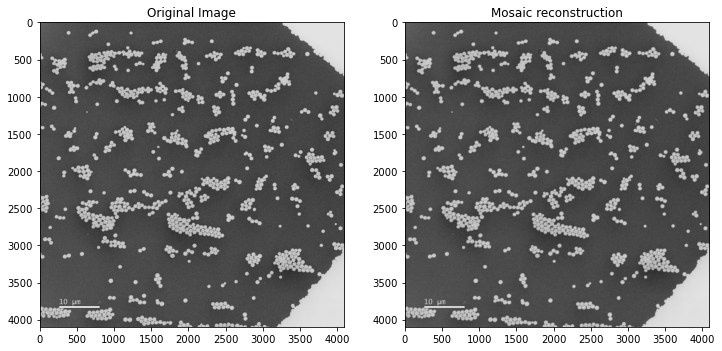

Mosaic shape: (64, 64, 128, 128, 3)


In [21]:
mosaic2 = MightyMosaic.from_array(tem_images[0], (128,128), overlap_factor=2, fill_mode='reflect')
plt.figure(figsize=(12, 12))
plt.subplot(121)
plt.title("Original Image")
plt.imshow(tem_images[0])
plt.subplot(122)
plt.title("Mosaic reconstruction")
plt.imshow(mosaic2.get_fusion(), interpolation='bilinear', vmin=0, vmax=1)
plt.show()
print("Mosaic shape: " + str(mosaic2.shape))

In [22]:
prediction2 = mosaic2.apply(model.predict, progress_bar=True)

In [23]:
fused_prediction2 = prediction2.get_fusion()
labels2 = np.argmax(fused_prediction2, axis=-1)

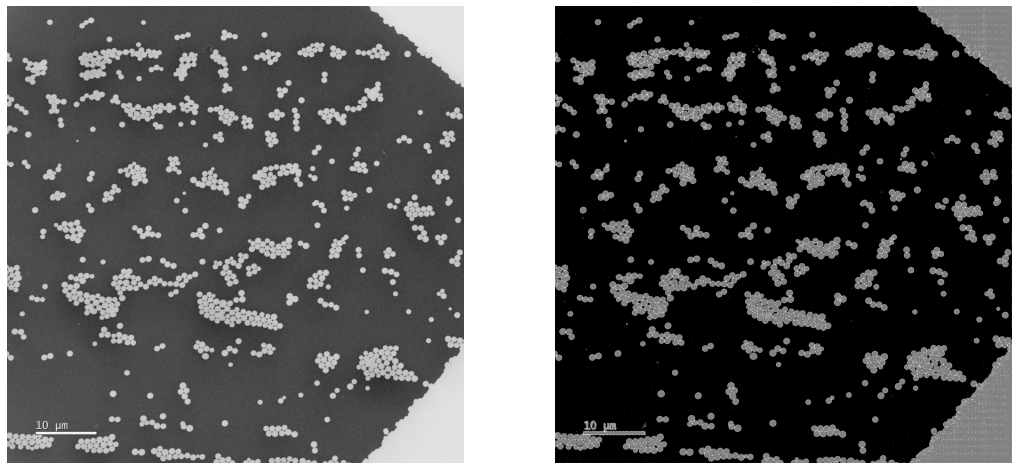

In [24]:
fig, axs = plt.subplots(1,2, figsize=(18,18))

axs[0].imshow(tem_images[0])
axs[0].axis('off')
axs[1].imshow(labels2, cmap=plt.cm.gray)
axs[1].axis('off')
plt.show()

name = os.path.split(images[0])[-1]
cv2.imwrite("segmented_" + name[:-4] + ".tif", labels2*127)
plt.show()

# Apply the watershed algorithm 

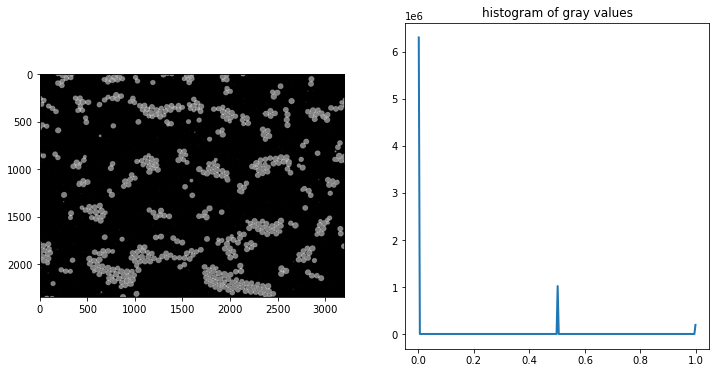

In [25]:
from skimage.exposure import histogram

# Crop to remove the sample plate
img = labels2[550:2900, :3200]/2#[2500:2900:,1600:2500]/2
hist, hist_centers = histogram(img)   # generate histogram data for cropped image

fig, axes = plt.subplots(1, 2, figsize=(12, 6))   # create figure with two sub-plots
axes[0].imshow(img, cmap=plt.cm.gray)   # display cropped image
axes[0].axis('on')
axes[1].plot(hist_centers, hist, lw=2)   # plot histogram
axes[1].set_title('histogram of gray values')
plt.show()

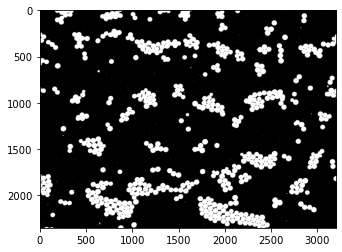

In [26]:
img[img==0.5] = 1
plt.figure(figsize=(8,4))
plt.imshow(img, cmap=plt.cm.gray)
plt.show()

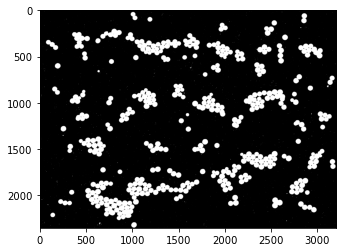

In [27]:
# Area opening removes all bright structures of an image with a surface smaller than area_threshold.
# Clear border remves objects touching the border of the image
#from skimage.morphology import area_opening()
from skimage.segmentation import clear_border
img = clear_border(img)
plt.imshow(img, cmap=plt.cm.gray)
plt.show()

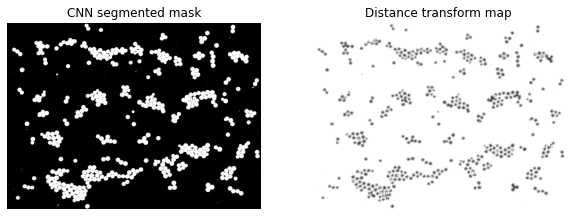

In [28]:
# turn objects into catchment basin using a distance map
dis = ndi.distance_transform_edt(img)
ndis = -dis

fig, axes = plt.subplots(1, 2, figsize=(10, 4))   # create figure with two sub-plots
axes[0].set_title('CNN segmented mask')
axes[0].imshow(img, cmap=plt.cm.gray)   # display binary image
axes[0].axis('off')
axes[1].set_title('Distance transform map')
axes[1].imshow(ndis, cmap=plt.cm.gray)   # display distance image
axes[1].axis('off')
plt.show()

In [29]:
# generate markers as local maxima in distance map
from skimage.feature import peak_local_max
locedge = 3
locreg  = np.ones((locedge, locedge))
locmax  = peak_local_max(dis, min_distance=25)   # particle centres near local maxima in distance map of eroded image

mask = np.zeros(dis.shape, dtype=bool)   # set up mask with same shape as distance map and pre-populate with False
mask[tuple(locmax.T)] = True   # set mask to True at coordinates of local maxima
markers, num_markers = ndi.label(mask, structure=None,)   # labels objects in mask, False or 0 is considered background
print("Number of markers     = {}".format(num_markers))

Number of markers     = 1908


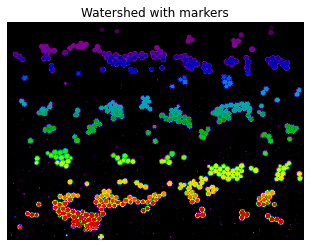

In [30]:
# now do watershed with markers
from skimage.segmentation import watershed
marker_watershed = watershed(ndis, markers=markers, mask=img, watershed_line=True)   # watershed and label image

fig, ax = plt.subplots(figsize=(10, 4))  
ax.set_title('Watershed with markers')
ax.imshow(marker_watershed, cmap=plt.cm.nipy_spectral)   
ax.axis('off')
plt.show()

In [31]:
# get region properties
from skimage.measure import regionprops
regprop = regionprops(marker_watershed)

# Loop through regprop and append area of each labeled object to list.
particles = []
cutoff_area = 500

for i in range(len(regprop)):
    area = regprop[i].area
    if area < cutoff_area:
        continue
    yc   = regprop[i].centroid[0]
    xc   = regprop[i].centroid[1]
    
    particles.append([yc,xc,area])

<ipython-input-32-3346be0385e4>:20: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  circ = Circle((xc,yc),rr,alpha=1.0,edgecolor='red',Fill=False,linewidth=0.5)


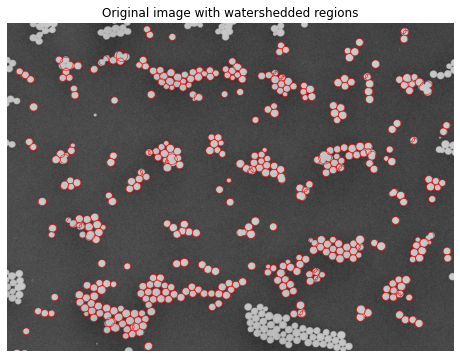

In [32]:
# check whether correct particles found by drawing particle centers
from matplotlib.patches import Circle
from math import sqrt, pi

# Create a figure. Equal aspect so circles look circular
fig,ax = plt.subplots(1, figsize=(8,8))
ax.set_aspect('equal')

# Show the image
ax.imshow(tem_images[0][550:2900, :3200], cmap=plt.cm.gray)
ax.set_title('Original image with watershedded regions')

# Now, loop through coord arrays, and create a circle at each x,y pair
rr = 1
for item in particles:
    area=item[2]
    xc = item[1]
    yc = item[0]
    rr = sqrt(item[2]/pi)
    circ = Circle((xc,yc),rr,alpha=1.0,edgecolor='red',Fill=False,linewidth=0.5)
    ax.add_patch(circ)

    # Show the image
plt.axis('off')
plt.savefig("model_2.2_" + name[:-4] + ".svg")
plt.show()

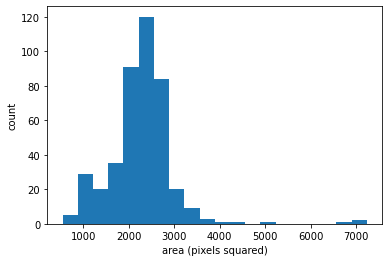

In [34]:
# plot histogram of radii
areas = []
for item in particles:
    area = item[2]
    areas.append(area)

# plot image histogram
areas_array = np.array(areas)

plt.hist(areas_array,bins=20)
plt.xlabel("area (pixels squared)")
plt.ylabel("count")
plt.savefig("s_distrbn_model_2.2.png")
plt.show()

# Run all TEM images through 

In [15]:
# for i, tem_image in enumerate(tem_images):
#     print(str(i+1) + ' of ' + str(len(tem_images)))
    
#     # Mosaic and predict
#     mosaic = MightyMosaic.from_array(tem_image, (128,128), overlap_factor=2, fill_mode='reflect')
#     prediction = mosaic.apply(model.predict, progress_bar=True)
    
#     clear_output()
    
#     # Fuse and get labels
#     fused_prediction = prediction.get_fusion()
#     labels = np.argmax(fused_prediction, axis=-1)

#     name = os.path.split(images[i])[-1]
    
#     cv2.imwrite("segmented_" + name[:-4] + ".tif", labels*127)

# Run an SEM image through prediction

In [7]:
path = "../full-size/sem/coated"

# File paths
images = load_data(path, tif=True)
print(f"Images: {len(images)}")

sem_images = [read_image(image) for image in images]
print(sem_images[0].shape)

sem_images = [1-img for img in sem_images]

Images: 2
(960, 1280, 3)


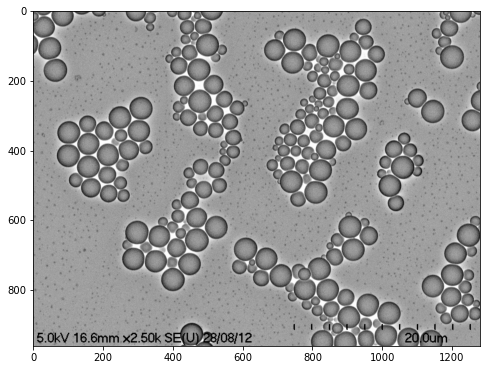

In [8]:
plt.figure(figsize=(8,8))
plt.imshow(sem_images[0])
plt.show()

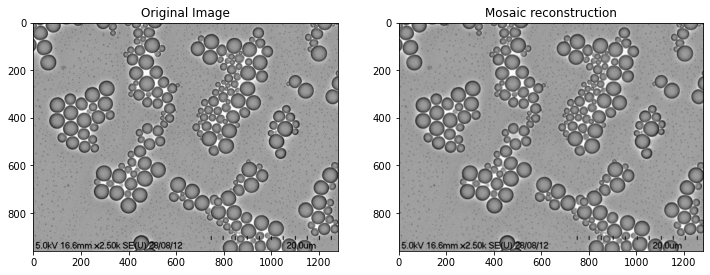

Mosaic shape: (16, 20, 128, 128, 3)


In [9]:
mosaic3 = MightyMosaic.from_array(sem_images[0], (128,128), overlap_factor=2, fill_mode='reflect')
plt.figure(figsize=(12, 12))
plt.subplot(121)
plt.title("Original Image")
plt.imshow(sem_images[0])
plt.subplot(122)
plt.title("Mosaic reconstruction")
plt.imshow(mosaic3.get_fusion(), interpolation='bilinear', vmin=0, vmax=1)
plt.show()
print("Mosaic shape: " + str(mosaic3.shape))

In [10]:
prediction3 = mosaic3.apply(model.predict, progress_bar=True)

In [11]:
fused_prediction3 = prediction3.get_fusion()
labels3 = np.argmax(fused_prediction3, axis=-1)

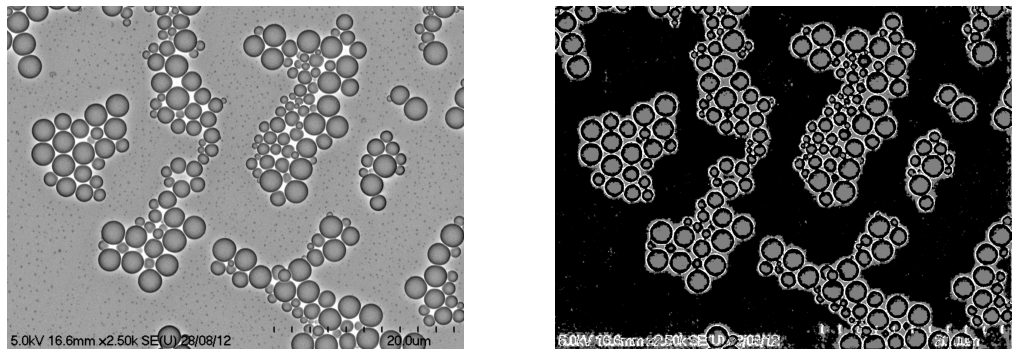

In [13]:
fig, axs = plt.subplots(1,2, figsize=(18,18))

axs[0].imshow(sem_images[0])
axs[0].axis('off')
axs[1].imshow(labels3, cmap=plt.cm.gray)
axs[1].axis('off')

name = os.path.split(images[0])[-1]
cv2.imwrite("segmented_" + name[:-4] + ".tif", labels3*127)
plt.show()